In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier , RandomForestRegressor

from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support,ConfusionMatrixDisplay,roc_auc_score, roc_curve, auc, classification_report
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE


import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import gzip as gz

**LOADING DATA**

In [ ]:
!kaggle datasets download -d cicdataset/cicids2017

 99% 227M/230M [00:04<00:00, 87.0MB/s]
100% 230M/230M [00:04<00:00, 57.8MB/s]


In [ ]:
!mkdir -p "/content/drive/My Drive/CICIDS2017/"
!cp cicids2017.zip "/content/drive/My Drive/CICIDS2017/"
!unzip "/content/drive/My Drive/CICIDS2017/cicids2017.zip"

Archive:  /content/drive/My Drive/CICIDS2017/cicids2017.zip
  inflating: MachineLearningCSV.md5  
  inflating: MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv  


In [ ]:
df1 = pd.read_csv("MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
df2 = pd.read_csv("MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df3 = pd.read_csv("MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv")
df4 = pd.read_csv("MachineLearningCSV/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv")
df5 = pd.read_csv("MachineLearningCSV/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
df6 = pd.read_csv("MachineLearningCSV/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df7 = pd.read_csv("MachineLearningCSV/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv")
df8 = pd.read_csv("MachineLearningCSV/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv")

In [ ]:
df = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8])

In [ ]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2830743 entries, 0 to 692702
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max          

DATA VISUALIZATION

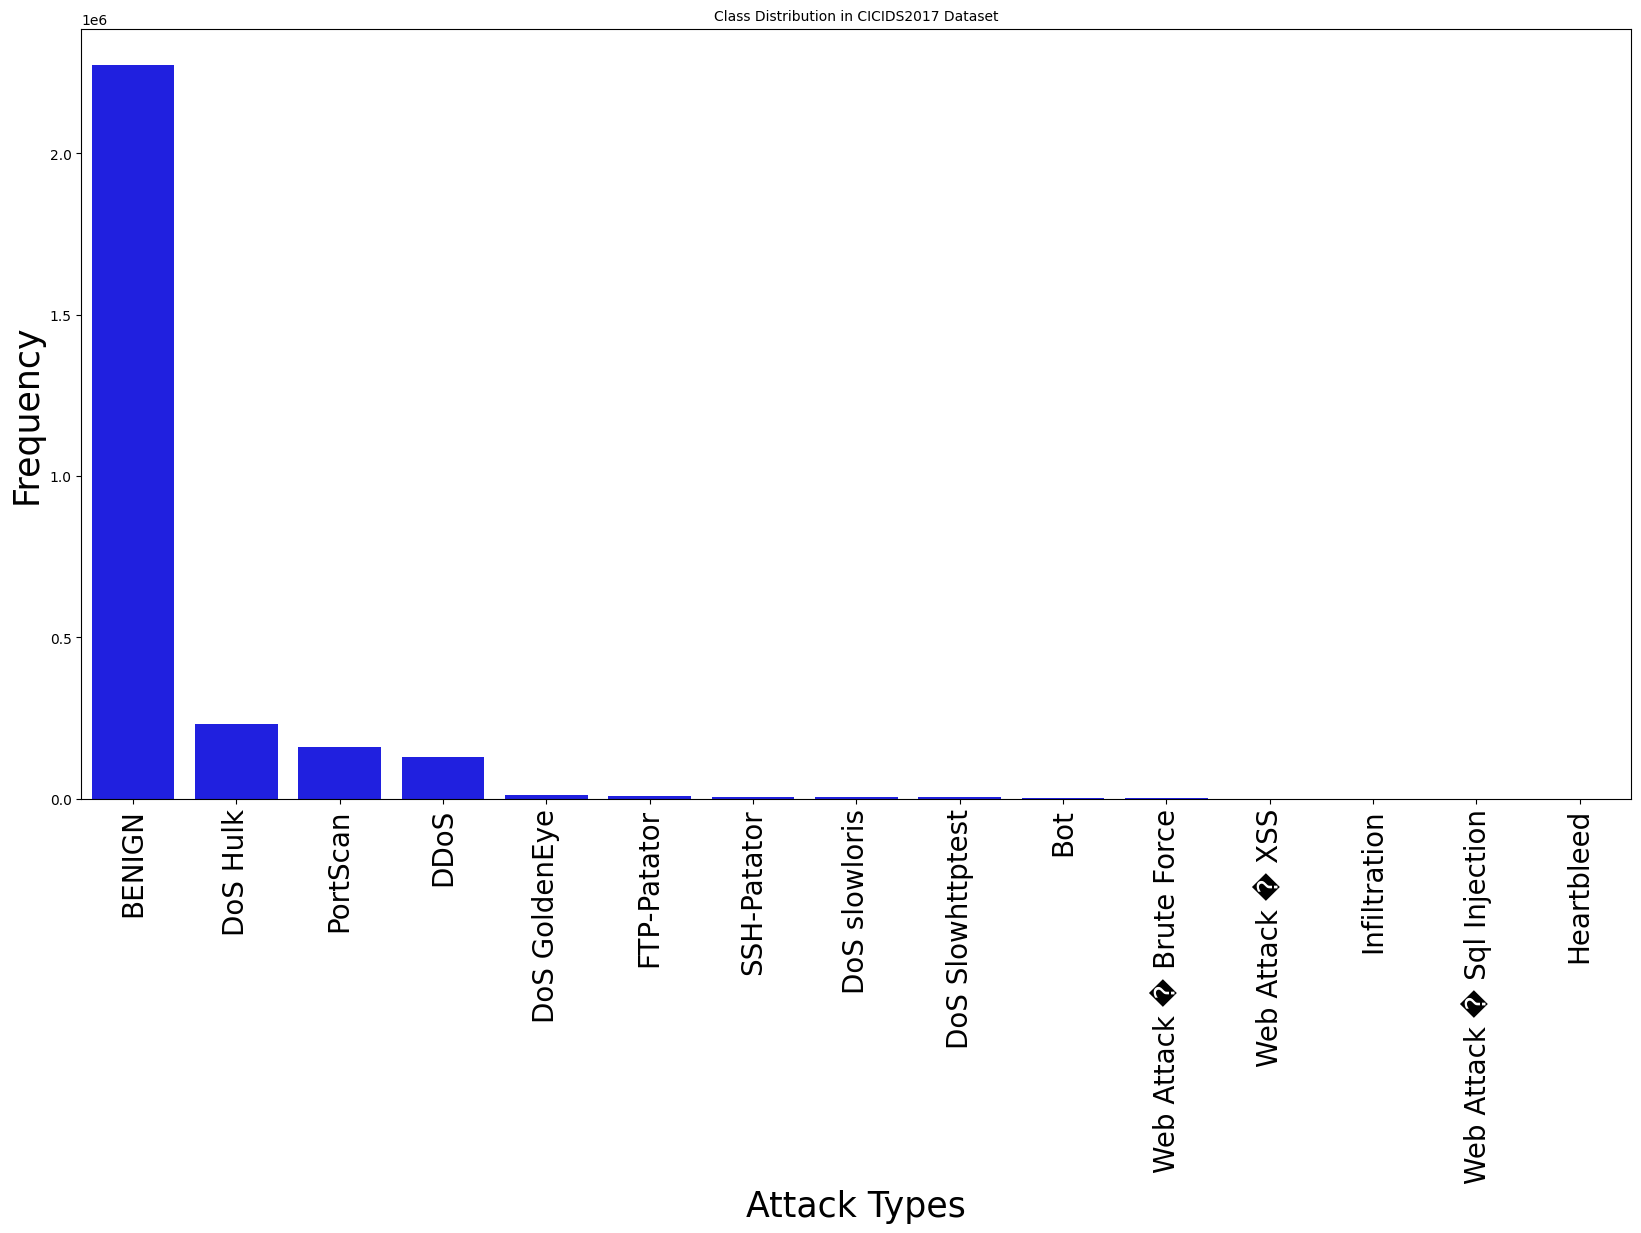

In [ ]:
# Generate the barplot
class_counts = df[' Label'].value_counts();
plt.figure(figsize=(20, 10))

sns.barplot(x=class_counts.index, y=class_counts.values, linewidth=2, color = 'blue')

# Rotate the x-axis labels for better reading
plt.xticks(rotation=90, fontsize=20)

# Set labels and title with increased font size
plt.xlabel('Attack Types', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
plt.title('Class Distribution in CICIDS2017 Dataset', fontsize=10)
plt.show()


*DATA PrOCESSING*

In [ ]:
#dropping columns with non uniue values through out their rows
identical_cols = []
for i in df.columns:
    if len(df[i].unique())==1:
        identical_cols.append(i)

print("Total columns with only 1 unique value:", len(identical_cols))
df.drop(columns = identical_cols, inplace=True)

Total columns with only 1 unique value: 8


In [ ]:
df.rename(columns = {' Label':'label'}, inplace = True)

df.replace([np.inf, -np.inf], np.nan, inplace =True)
df.dropna(inplace = True)

In [ ]:
df['label'].value_counts()


BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: label, dtype: int64

In [ ]:
df['label'] = df['label'].replace(['Web Attack � Brute Force','Web Attack � Sql Injection','Web Attack � XSS'],'Web Attack')

df['label'] = df['label'].replace(['DoS Hulk', 'DDoS','DoS slowloris', 'DoS Slowhttptest', 'DoS GoldenEye'],'Dos')


df['label_bi'] = df['label'].apply(lambda x: 'benign' if x == 'BENIGN' else 'attack')

In [ ]:
df.label.value_counts()

BENIGN          2271320
Dos              379737
PortScan         158804
FTP-Patator        7935
SSH-Patator        5897
Web Attack         2180
Bot                1956
Infiltration         36
Heartbleed           11
Name: label, dtype: int64

In [ ]:
df.label_bi.value_counts()

benign    2271320
attack     556556
Name: label_bi, dtype: int64

In [ ]:
df.label.value_counts()


BENIGN          2271320
Dos              379737
PortScan         158804
FTP-Patator        7935
SSH-Patator        5897
Web Attack         2180
Bot                1956
Infiltration         36
Heartbleed           11
Name: label, dtype: int64

In [ ]:
integer = []
f = []
for i in df.columns[:-2]:
    if df[i].dtype == "int64":
      integer.append(i)
    else:
      f.append(i)

df[integer] = df[integer].astype("int32")
df[f] = df[f].astype("float32")

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2827876 entries, 0 to 692702
Data columns (total 72 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int32  
 1    Flow Duration                int32  
 2    Total Fwd Packets            int32  
 3    Total Backward Packets       int32  
 4   Total Length of Fwd Packets   int32  
 5    Total Length of Bwd Packets  int32  
 6    Fwd Packet Length Max        int32  
 7    Fwd Packet Length Min        int32  
 8    Fwd Packet Length Mean       float32
 9    Fwd Packet Length Std        float32
 10  Bwd Packet Length Max         int32  
 11   Bwd Packet Length Min        int32  
 12   Bwd Packet Length Mean       float32
 13   Bwd Packet Length Std        float32
 14  Flow Bytes/s                  float32
 15   Flow Packets/s               float32
 16   Flow IAT Mean                float32
 17   Flow IAT Std                 float32
 18   Flow IAT Max          

DATA SPLIT

In [ ]:
labelencoder = LabelEncoder()
df['label'], df['label_bi'] = labelencoder.fit_transform(df['label']), labelencoder.fit_transform(df['label_bi'])
x = df.drop(columns=['label_bi', 'label'],axis=1)
y = labelencoder.fit_transform(df['label_bi'])
y=np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(x,y, train_size = 0.7, test_size = 0.3, random_state = 0, stratify = y)


## Feature selection:

Features sorted by their score:
[(0.0775, ' Bwd Packet Length Mean'), (0.0635, ' Packet Length Std'), (0.0572, ' Average Packet Size'), (0.0552, ' Destination Port'), (0.0531, ' Bwd Packet Length Std'), (0.0484, ' Packet Length Variance'), (0.0448, ' Avg Bwd Segment Size'), (0.042, ' Packet Length Mean'), (0.0353, 'Bwd Packet Length Max'), (0.0298, 'Init_Win_bytes_forward'), (0.0297, 'Total Length of Fwd Packets'), (0.0283, ' Max Packet Length'), (0.0274, ' Total Length of Bwd Packets'), (0.0242, ' Fwd Header Length'), (0.0224, ' Subflow Fwd Bytes'), (0.0222, ' Fwd Packet Length Max'), (0.0209, ' Subflow Bwd Bytes'), (0.0173, ' Bwd Header Length'), (0.0171, ' Init_Win_bytes_backward'), (0.0165, ' Fwd Header Length.1'), (0.0126, ' Flow IAT Std'), (0.0125, ' Fwd IAT Max'), (0.0118, ' Subflow Bwd Packets'), (0.0116, ' Flow IAT Max'), (0.0115, ' min_seg_size_forward'), (0.0107, ' Fwd Packet Length Mean'), (0.0106, ' Fwd IAT Std'), (0.0106, ' Bwd Packets/s'), (0.0102, 'Fwd Packets/s'), (0.0

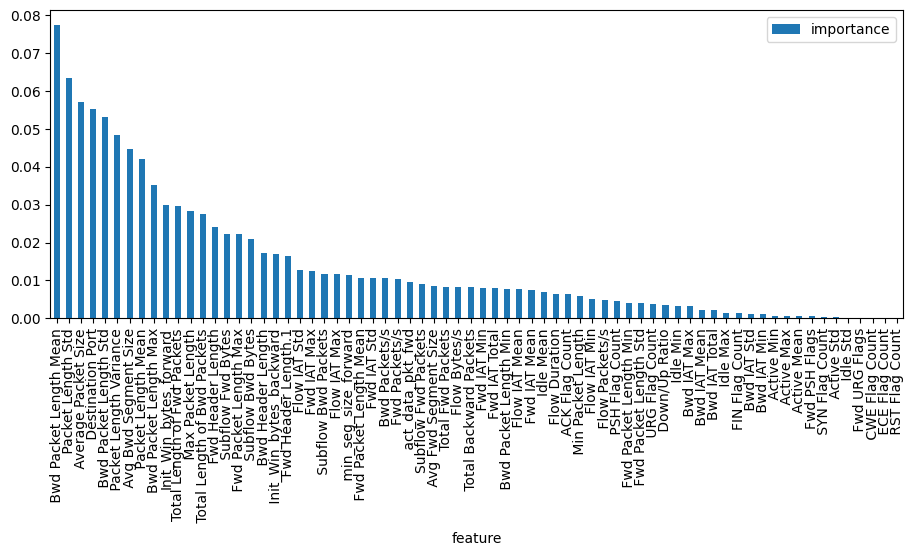

In [ ]:
feature=(df.drop(['label', 'label_bi'],axis=1)).columns.values



from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();
# fit random forest classifier on the training set
rfc.fit(x, y);
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), feature), reverse=True))
importances = pd.DataFrame({'feature':feature,'importance':rfc.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

# Algo to determine attack or not  

Random Forest Accuracy:0.9988342254435896
Random Forest precision_recall_fscore:0.99883406441170790.99883422544358960.9988341344889416


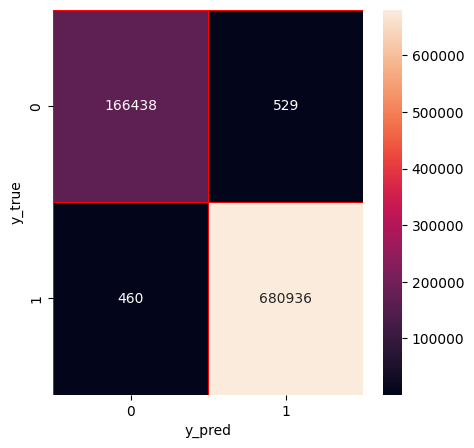

In [ ]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train)
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test

print('Random Forest Accuracy:'+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Random Forest precision_recall_fscore:'+(str(precision))+(str(recall))+(str(fscore)))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [ ]:
print(classification_report(y_true, y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    166967
           1       1.00      1.00      1.00    681396

    accuracy                           1.00    848363
   macro avg       1.00      1.00      1.00    848363
weighted avg       1.00      1.00      1.00    848363



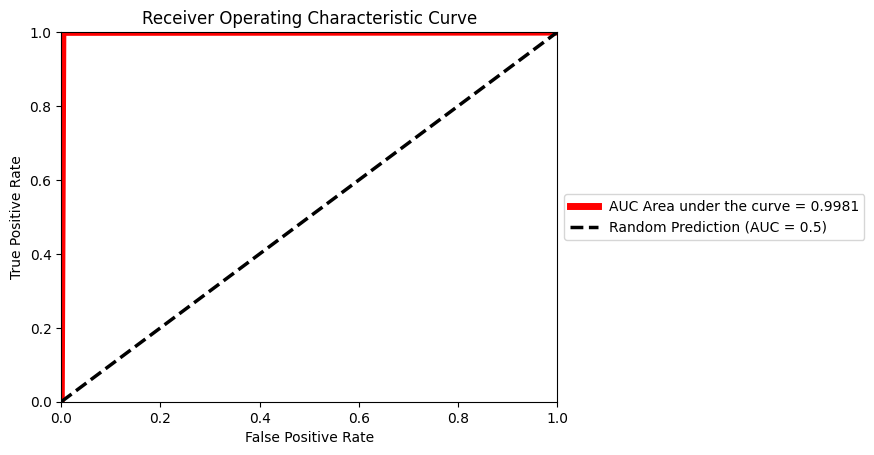

In [ ]:
fpr, tpr, th = roc_curve(y_true, y_predict)
roc_auc = auc(fpr, tpr)
fpr, tpr, th = roc_curve(y_true, y_predict)
%matplotlib inline
plt.plot(fpr, tpr, color ='red', lw = 5, label = f'AUC Area under the curve = %0.4f' % roc_auc)
plt.title('Receiver Operating Characteristic Curve')
lw = 2.5
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--',
label='Random Prediction (AUC = 0.5)' )
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**ALGORITHM TO DETERMINE TYPE OF ATTACK **

In [ ]:
second_classifier = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8])

In [ ]:
second_classifier = second_classifier.loc[second_classifier[' Label'] != 'BENIGN']
second_classifier =  second_classifier.dropna()
second_classifier.rename(columns = {' Label':'label'}, inplace = True)
second_classifier.replace([np.inf, -np.inf], np.nan, inplace =True)
second_classifier.dropna(inplace = True)

<ipython-input-12-cc79bb83b46e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_classifier.rename(columns = {' Label':'label'}, inplace = True)


In [ ]:
second_classifier['label'] = second_classifier['label'].replace(['Web Attack � Brute Force','Web Attack � Sql Injection','Web Attack � XSS'],'Web Attack')
second_classifier['label'] = second_classifier['label'].replace(['DoS Hulk', 'DDoS','DoS slowloris', 'DoS Slowhttptest', 'DoS GoldenEye'],'Dos')

In [ ]:
data = second_classifier.values
# split into input and output elements
X, y = data[:, :-1], data[:, -1]
# label encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)



In [ ]:
labels = list(le.classes_)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, test_size = 0.3, random_state = 0, stratify = y)

Decision Tree0.9999539154831907
Decision Tree:0.99995391638822020.99995391548319070.999953915121889


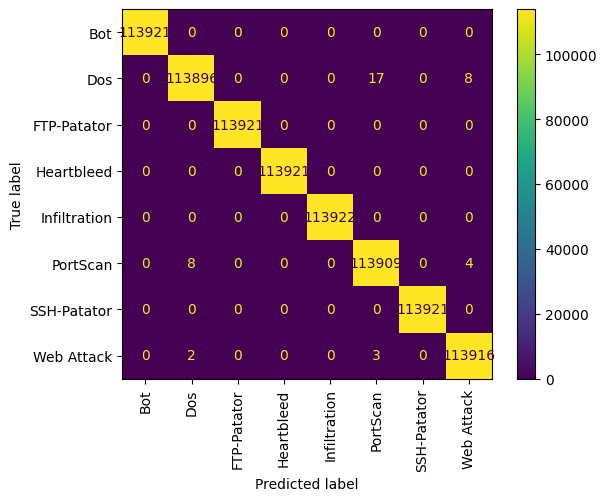

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
labels = labels
score=dt.score(X_test,y_test)

print('Decision Tree'+ str(score))
y_predict=dt.predict(X_test)
y_true=y_test
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')


print('Decision Tree:'+(str(precision))+(str(recall))+(str(fscore)))
cm=confusion_matrix(y_true,y_predict)
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_predict, display_labels=labels, xticks_rotation = 'vertical')





In [ ]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    113921
           1       1.00      1.00      1.00    113921
           2       1.00      1.00      1.00    113921
           3       1.00      1.00      1.00    113921
           4       1.00      1.00      1.00    113922
           5       1.00      1.00      1.00    113921
           6       1.00      1.00      1.00    113921
           7       1.00      1.00      1.00    113921

    accuracy                           1.00    911369
   macro avg       1.00      1.00      1.00    911369
weighted avg       1.00      1.00      1.00    911369

